In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
customers=pd.read_csv('olist_customers_dataset.csv')
geoloc=pd.read_csv('olist_geolocation_dataset.csv')
items=pd.read_csv('olist_order_items_dataset.csv')
payments=pd.read_csv('olist_order_payments_dataset.csv')
reviews=pd.read_csv('olist_order_reviews_dataset.csv')
orders=pd.read_csv('olist_orders_dataset.csv')
products=pd.read_csv('olist_products_dataset.csv')
sellers=pd.read_csv('olist_sellers_dataset.csv')
category=pd.read_csv('product_category_name_translation.csv')


In [155]:
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [4]:
print(len(customers.customer_unique_id.unique()),len(customers[customers.duplicated(subset='customer_unique_id')].customer_unique_id.unique()))

96096 2997


In [5]:
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [6]:
#On a donc 96096 clients différents parmi lesquels 2997 ont effectués plusieurs achats
#visualisons la distribution des clients par villes et par état
#Pour cela on crée un dataframe avec en index l'id unique des customers
data=customers.groupby('customer_unique_id').agg(number_of_orders=pd.NamedAgg(column='customer_id',aggfunc='count'),\
                                                city=pd.NamedAgg(column='customer_city',aggfunc='first'),\
                                                state=pd.NamedAgg(column='customer_state',aggfunc='first'),\
                                                zip_code=pd.NamedAgg(column='customer_zip_code_prefix',aggfunc='first'))

In [7]:
data.head()

,number_of_orders,city,state,zip_code
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,cajamar,SP,7787
0000b849f77a49e4a4ce2b2a4ca5be3f,1,osasco,SP,6053
0000f46a3911fa3c0805444483337064,1,sao jose,SC,88115
0000f6ccb0745a6a4b88665a16c9f078,1,belem,PA,66812
0004aac84e0df4da2b147fca70cf8255,1,sorocaba,SP,18040


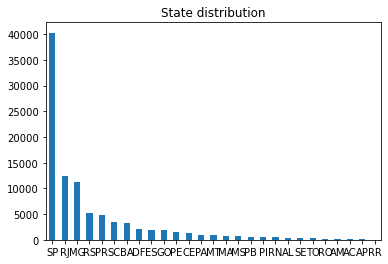

In [8]:
data.state.value_counts().plot(kind='bar', title="State distribution",rot=0)

In [9]:
data.city.value_counts()

sao paulo         14971
rio de janeiro     6611
belo horizonte     2671
brasilia           2066
curitiba           1462
                  ...  
isaias coelho         1
mira estrela          1
santo expedito        1
pio ix                1
novo lino             1
Name: city, Length: 4118, dtype: int64

In [10]:
#Au final la répartition par état est très inégales, on va surement garder cet aspect et la privilégier sur la ville

In [11]:
#On va donc rajouter la position gps approximative du client:


In [12]:
geoloc.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [13]:
#Dans la mesure où les orthographes des villes changent parfois,
#On va prendre les doublons, zip codes et états car certains zipcodes sont sur plusieurs états

gps=geoloc.groupby(['geolocation_zip_code_prefix','geolocation_state'])\
.agg(Latitude=pd.NamedAgg(column='geolocation_lat', aggfunc='mean'),\
     Longitude=pd.NamedAgg(column='geolocation_lng', aggfunc='mean'))

In [14]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [15]:
#On indique la position GPS des customer et des vendeurs
data=pd.merge(data,gps,left_on=['zip_code','state'],right_index=True,how='left')
sellers=pd.merge(sellers,gps,left_on=['seller_zip_code_prefix','seller_state'],right_index=True,how='left')

In [16]:
sellers.isnull().sum()

seller_id                  0
seller_zip_code_prefix     0
seller_city                0
seller_state               0
Latitude                  42
Longitude                 42
dtype: int64

In [17]:
data.isnull().sum()

number_of_orders      0
city                  0
state                 0
zip_code              0
Latitude            268
Longitude           268
dtype: int64

In [18]:
#pour les 268 et 42 restants on va faire un knn imputer à partir des 3 plus proches sur le zip code
from sklearn.impute import KNNImputer
knn=KNNImputer(n_neighbors=3)
X=knn.fit_transform(data[data.columns.tolist()[3:]])
Y=knn.fit_transform(sellers[['seller_zip_code_prefix']+sellers.columns.tolist()[4:]])

In [19]:
sellers['Latitude']=Y[:,1]
sellers['Longitude']=Y[:,2]
sellers.isnull().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
Latitude                  0
Longitude                 0
dtype: int64

In [20]:
data['Latitude']=X[:,1]
data['Longitude']=X[:,2]
data.isnull().sum()

number_of_orders    0
city                0
state               0
zip_code            0
Latitude            0
Longitude           0
dtype: int64

In [21]:
data.drop(['city','zip_code'],axis=1,inplace=True)

In [22]:
data.shape

(96096, 4)

In [23]:
data.isnull().sum()

number_of_orders    0
state               0
Latitude            0
Longitude           0
dtype: int64

In [24]:
data.head()

,number_of_orders,state,Latitude,Longitude
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,SP,-23.340235,-46.830140
0000b849f77a49e4a4ce2b2a4ca5be3f,1,SP,-23.559115,-46.787626
0000f46a3911fa3c0805444483337064,1,SC,-27.542880,-48.633426
0000f6ccb0745a6a4b88665a16c9f078,1,PA,-1.312214,-48.483159
0004aac84e0df4da2b147fca70cf8255,1,SP,-23.505548,-47.469705


In [157]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,time,période_achat
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,10,morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,20,evening


In [26]:
orders.shape

(99441, 8)

In [27]:
customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [28]:
#A partir de là on va déduire la durée depuis le dernier achat et le temps moyen entre 2 achats pour les clients
#de multiple:
orders['order_purchase_timestamp']=pd.to_datetime(orders['order_purchase_timestamp'])
cust_orders=pd.merge(customers[['customer_id', 'customer_unique_id']],orders[['order_id','customer_id','order_purchase_timestamp']],on='customer_id')

In [29]:
cust_orders.shape

(99441, 4)

In [30]:
cust_orders.head()

,customer_id,customer_unique_id,order_id,order_purchase_timestamp
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30


In [31]:
time=cust_orders.groupby('customer_unique_id').agg(first_order=pd.NamedAgg(column='order_purchase_timestamp',aggfunc='min'),
                                                  last_order=pd.NamedAgg(column='order_purchase_timestamp',aggfunc='max'))

In [32]:
print(time.shape,data.shape)

(96096, 2) (96096, 4)


In [33]:
data=pd.concat([time,data],axis=1)

In [34]:
data.head()

,first_order,last_order,number_of_orders,state,Latitude,Longitude
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,1,SP,-23.340235,-46.830140
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,1,SP,-23.559115,-46.787626
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,1,SC,-27.542880,-48.633426
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,1,PA,-1.312214,-48.483159
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,1,SP,-23.505548,-47.469705


In [35]:
data.isnull().sum()

first_order         0
last_order          0
number_of_orders    0
state               0
Latitude            0
Longitude           0
dtype: int64

In [36]:
payments.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [37]:
data.last_order.max()

Timestamp('2018-10-17 17:30:18')

# on va extraire l'heure moyenne d'achat


In [38]:
orders['time']=orders['order_purchase_timestamp'].apply(lambda x:pd.Timestamp(x).hour)

(array([2394., 1170.,  510.,  272.,  206.,  188.,  502., 1231., 2967.,
        4785., 6177., 6578., 5995., 6518., 6569., 6454., 6675., 6150.,
        5769., 5982., 6193., 6217., 5816., 4123.]),
 array([ 0.        ,  0.95833333,  1.91666667,  2.875     ,  3.83333333,
         4.79166667,  5.75      ,  6.70833333,  7.66666667,  8.625     ,
         9.58333333, 10.54166667, 11.5       , 12.45833333, 13.41666667,
        14.375     , 15.33333333, 16.29166667, 17.25      , 18.20833333,
        19.16666667, 20.125     , 21.08333333, 22.04166667, 23.        ]),
 <a list of 24 Patch objects>)

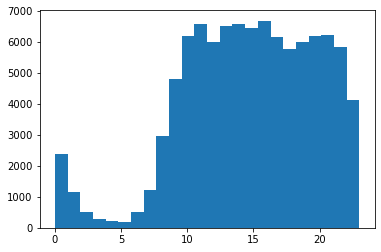

In [39]:
plt.hist(orders['time'],bins=24)

In [40]:
#On va définir des plages horaires et voir quand les clients achètent le plus souvent:
#matin entre 6h et 12h
#après midi: entre 12h et 19h
#Soir entre 19h et 23h
#nuit entre 23h et 6h
orders['période_achat']=np.where(orders['time']>23,'night',\
                                 (np.where(orders['time']>=19,'evening',\
                                           np.where(orders['time']>=12,'afternoon',\
                                                    np.where(orders['time']>=6,'morning','night')))))

In [41]:
def heure(t):
    """ Retourne si le client achète plus souvent le matin, le soir, la nuit ou la journée"""
    
    df=orders[orders.order_purchase_timestamp<t][['order_id','customer_id','période_achat']]
    
    #On joint à droite, on a déjà éliminé l'order sans paiement    
    final=pd.merge(df,customers[['customer_id','customer_unique_id']],on='customer_id',how='left')
    #On prends l'occurence la plus fréquente
    g=final.groupby('customer_unique_id').agg(periode=('période_achat',lambda x:x.value_counts().index[0]))
    return pd.DataFrame(g)    

In [42]:
h=heure('2018-10-17 17:30:19')

In [43]:
data=data.join(h)

In [44]:
payments.sort_values('order_id')

,order_id,payment_sequential,payment_type,payment_installments,payment_value
85283,00010242fe8c5a6d1ba2dd792cb16214,1,credit_card,2,72.19
2499,00018f77f2f0320c557190d7a144bdd3,1,credit_card,3,259.83
12393,000229ec398224ef6ca0657da4fc703e,1,credit_card,5,216.87
32971,00024acbcdf0a6daa1e931b038114c75,1,credit_card,2,25.78
98711,00042b26cf59d7ce69dfabb4e55b4fd9,1,credit_card,3,218.04
...,...,...,...,...,...
69123,fffc94f6ce00a00581880bf54a75a037,1,boleto,1,343.40
2776,fffcd46ef2263f404302a634eb57f7eb,1,boleto,1,386.53
58888,fffce4705a9662cd70adb13d4a31832d,1,credit_card,3,116.85
37089,fffe18544ffabc95dfada21779c9644f,1,credit_card,3,64.71


In [45]:
#On va récupérer le montant de la dernière commande
#On va récupérer le montant moyen des installments pour avoir un indicateur de pouvoir d'achat
#On va aussi récupérer le mode de paiement principal
len(payments.order_id.unique())

99440

In [46]:
orders.shape

(99441, 10)

In [47]:
#Au final un order n'a pas été payé, on l'exclu de la base de donnée finale


In [48]:
def montant(t):
    """ calcule le montant total des commandes effectuées avant la date t\n\
    retourne un dataframe avec en indice les customer_unique_id et en feature le montant total"""
    
    df=orders[orders.order_purchase_timestamp<=t][['order_id','customer_id']]
    
    df2=pd.merge(payments[['order_id','payment_value']],df,on='order_id',how='left')
    
    final=pd.merge(df2,customers[['customer_id','customer_unique_id']],on='customer_id',how='left')
    g=final.groupby('customer_unique_id').aggregate({'payment_value':'sum'})
    return pd.DataFrame(g)

In [49]:
data=data.join(montant('2018-10-17 17:30:19'))

In [50]:
data

,first_order,last_order,number_of_orders,state,Latitude,Longitude,periode,payment_value
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,1,SP,-23.340235,-46.830140,morning,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,1,SP,-23.559115,-46.787626,morning,27.19
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,1,SC,-27.542880,-48.633426,evening,86.22
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,1,PA,-1.312214,-48.483159,evening,43.62
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,1,SP,-23.505548,-47.469705,evening,196.89
...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,2017-06-08 21:00:36,1,PE,-8.362511,-36.562343,evening,2067.42
fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,2017-12-10 20:07:56,1,BA,-12.217395,-38.959308,evening,84.58
ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,2017-02-07 15:49:16,1,MT,-11.834552,-55.508110,afternoon,112.46


In [51]:
#je vérifie:
print(payments['payment_value'].sum(),data['payment_value'].sum())

16008872.12 16008872.12


In [52]:
data.isnull().sum()

first_order         0
last_order          0
number_of_orders    0
state               0
Latitude            0
Longitude           0
periode             0
payment_value       1
dtype: int64

In [53]:
data.dropna(how='any',inplace=True)

In [54]:
#on regarde les payments qui valent 0:
data[data.payment_value==0]

,first_order,last_order,number_of_orders,state,Latitude,Longitude,periode,payment_value
customer_unique_id,,,,,,,,
4fa4365000c7090fcb8cad5713c6d3db,2018-08-28 15:26:39,2018-08-28 15:26:39,1,SP,-23.531642,-46.656289,afternoon,0.0
968fac81e2c44fb6c1e3ac2a45e6a102,2018-09-03 14:14:25,2018-09-03 14:14:25,1,SP,-23.663211,-46.693516,afternoon,0.0


In [55]:
#On supprime ces deux personnes qui sont au final des outliers:
data=data[data.payment_value>0]

In [56]:
data.shape

(96093, 8)

In [57]:
payments[payments.payment_installments<=0]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
46982,744bade1fcf9ff3f31d860ace076d422,2,credit_card,0,58.69
79014,1a57108394169c0b47d8f876acc9ba2d,2,credit_card,0,129.94


In [58]:
#on passe ces valeurs à 1:
payments['payment_installments']=payments['payment_installments'].apply(lambda x: 1 if x==0 else x)

In [59]:
def mean_installment(t):
    """ calcule le montant total des installments pour les commande t\n\
    Ajoute tous les installments par order
    divise le prix total de la commande par le nombre d'installments
    fait la moyenne sur toutes les commandes
    retourne un dataframe avec en indice les customer_unique_id et en feature le montant"""
    
    df=orders[orders.order_purchase_timestamp<t][['order_id','customer_id']]
    
    #On joint à droite, on a déjà éliminé l'order sans paiement
    df2=pd.merge(df,payments[['order_id','payment_value','payment_installments']],on='order_id',how='right')
    
    df3=pd.DataFrame(df2.groupby('order_id').aggregate({'payment_value':'sum','payment_installments':'sum','customer_id':'first'})).reset_index()
    
    df3['mean_installment']=df3['payment_value']/df3['payment_installments']
    
    final=pd.merge(df3,customers[['customer_id','customer_unique_id']],on='customer_id',how='left')
    g=final.groupby('customer_unique_id').aggregate({'mean_installment':'mean'})
    return pd.DataFrame(g)

In [60]:
mean_installment('2018-10-17 17:30:19')

,mean_installment
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,17.7375
0000b849f77a49e4a4ce2b2a4ca5be3f,27.1900
0000f46a3911fa3c0805444483337064,10.7775
0000f6ccb0745a6a4b88665a16c9f078,10.9050
0004aac84e0df4da2b147fca70cf8255,32.8150
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,206.7420
fffea47cd6d3cc0a88bd621562a9d061,84.5800
ffff371b4d645b6ecea244b27531430a,112.4600


In [61]:
a=mean_installment('2018-10-17 17:30:19')

In [62]:
data=data.join(a)

In [63]:
data.shape

(96093, 9)

In [64]:
data.isnull().sum()

first_order         0
last_order          0
number_of_orders    0
state               0
Latitude            0
Longitude           0
periode             0
payment_value       0
mean_installment    0
dtype: int64

In [65]:
data.columns=['first_order', 'last_order', 'number_of_orders', 'state', 'Latitude','Longitude','period','total_payment_value', 'mean_installment']

In [66]:
payments['payment_type'].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

In [67]:
def favorite_payment_type(t):
    """ calcule le moyen favori de paiment avant la date t\n\
    retourne un dataframe avec en indice les customer_unique_id et en feature le montant total
    celui qui le plus été utilisé sur toutes les séquences de paiement"""
    
    df=orders[orders.order_purchase_timestamp<t][['order_id','customer_id']]
    
    df2=pd.merge(df,payments[['order_id','payment_type']],on='order_id',how='right')
    
    final=pd.merge(df2,customers[['customer_id','customer_unique_id']],on='customer_id',how='left')
    
    g=final.groupby('customer_unique_id').agg(favorite_payment=('payment_type',lambda x:x.value_counts().index[0]))
    return pd.DataFrame(g)

In [68]:
fp=favorite_payment_type('2021-03-07 21:08:44')

In [69]:
fp

,favorite_payment
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,credit_card
0000b849f77a49e4a4ce2b2a4ca5be3f,credit_card
0000f46a3911fa3c0805444483337064,credit_card
0000f6ccb0745a6a4b88665a16c9f078,credit_card
0004aac84e0df4da2b147fca70cf8255,credit_card
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,credit_card
fffea47cd6d3cc0a88bd621562a9d061,credit_card
ffff371b4d645b6ecea244b27531430a,credit_card


In [70]:
print(fp['favorite_payment'].unique(),fp.shape)

['credit_card' 'boleto' 'voucher' 'debit_card' 'not_defined'] (96095, 1)


In [71]:
data=data.join(fp)

In [72]:
data.shape

(96093, 10)

In [73]:
data.isnull().sum()

first_order            0
last_order             0
number_of_orders       0
state                  0
Latitude               0
Longitude              0
period                 0
total_payment_value    0
mean_installment       0
favorite_payment       0
dtype: int64

In [74]:
#On passe au tableau suivant:


In [158]:
items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [76]:
items[items.product_id=='1a0d662b65b5ef08796501b064c853af']


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
326,00c9f7d4b0e87781465e562dc109f6aa,1,1a0d662b65b5ef08796501b064c853af,2e0dba2da448400b1c11d7b4b22f32a4,2017-05-26 19:25:17,14.99,15.1
327,00c9f7d4b0e87781465e562dc109f6aa,2,1a0d662b65b5ef08796501b064c853af,2e0dba2da448400b1c11d7b4b22f32a4,2017-05-26 19:25:17,14.99,15.1
328,00c9f7d4b0e87781465e562dc109f6aa,3,1a0d662b65b5ef08796501b064c853af,2e0dba2da448400b1c11d7b4b22f32a4,2017-05-26 19:25:17,14.99,15.1
329,00c9f7d4b0e87781465e562dc109f6aa,4,1a0d662b65b5ef08796501b064c853af,2e0dba2da448400b1c11d7b4b22f32a4,2017-05-26 19:25:17,14.99,15.1


In [77]:
items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [78]:
print(len(items.order_id.unique()),len(orders.order_id.unique()))

98666 99441


In [79]:
#Ici on va regarder la part moyen du fret dans l'achat pour voir dans quelle mesure un client
#se moque complètement du cout d'acheminement du produit
#On va regarder également le vendeur favori de chaque client
#Et le nombre moyen d'item par order

In [80]:
def freight(t):
    """ calcule le pourcentage du prix du fret par order avant la date t
    renvois la moyenne de pourcentage sur l'ensemble des commandes"""
    
    df=orders[orders.order_purchase_timestamp<t][['order_id','customer_id']]
    
    df2=pd.merge(items[['order_id','price','freight_value']],df,on='order_id',how='left')
    price_order=df2.groupby(['order_id']).aggregate({'price':'sum','freight_value':'sum','customer_id':'first'})
    price_order['ratio_freight']=price_order['freight_value']/(price_order['price']+price_order['freight_value'])
    
    cust_freight=pd.merge(price_order[['customer_id','ratio_freight']],customers[['customer_id','customer_unique_id']],on='customer_id',how='left')
    return pd.DataFrame(cust_freight.groupby('customer_unique_id').aggregate({'ratio_freight':'mean'}))

In [81]:
a=freight('2021-03-07 21:08:44')

In [82]:
a.shape

(95420, 1)

In [83]:
99441-98666

775

In [84]:
#On a donc quelques clients pour lesquels on a pas d'information sur les produits commandés
#On supprime ces clients de la base de donnée en joignant les deux tableaux

In [85]:
data=pd.merge(data,a,left_index=True,right_index=True,how='right')

In [86]:
data.shape

(95420, 11)

In [87]:
data.head()

,first_order,last_order,number_of_orders,state,Latitude,Longitude,period,total_payment_value,mean_installment,favorite_payment,ratio_freight
customer_unique_id,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,1.0,SP,-23.340235,-46.830140,morning,141.90,17.7375,credit_card,0.084567
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,1.0,SP,-23.559115,-46.787626,morning,27.19,27.1900,credit_card,0.304892
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,1.0,SC,-27.542880,-48.633426,evening,86.22,10.7775,credit_card,0.199722
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,1.0,PA,-1.312214,-48.483159,evening,43.62,10.9050,credit_card,0.404172
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,1.0,SP,-23.505548,-47.469705,evening,196.89,32.8150,credit_card,0.085784


In [88]:
data.isnull().sum()

first_order            1
last_order             1
number_of_orders       1
state                  1
Latitude               1
Longitude              1
period                 1
total_payment_value    1
mean_installment       1
favorite_payment       1
ratio_freight          0
dtype: int64

In [89]:
#l'une des transactions éliminée auparavant est incluse dans les items, on la supprime:
data.dropna(how='any',inplace=True)

In [90]:
data.shape

(95419, 11)

In [91]:
def item(t):
    """ calcule le nombre moyen d'item par order
    renvois la moyenne sur l'ensemble des commandes"""
    
    df=orders[orders.order_purchase_timestamp<t][['order_id','customer_id']]
    
    df2=pd.merge(items[['order_id','product_id']],df,on='order_id',how='left')
    
    item_order=df2.groupby(['order_id']).aggregate({'product_id':'count','customer_id':'first'})
    
    cust_item_order=pd.merge(item_order[['customer_id','product_id']],customers[['customer_id','customer_unique_id']],on='customer_id',how='left')
    
    return pd.DataFrame(cust_item_order.groupby('customer_unique_id').aggregate({'product_id':'mean'}))

In [92]:
item('2021-03-07 21:08:44')

,product_id
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1.0
0000f46a3911fa3c0805444483337064,1.0
0000f6ccb0745a6a4b88665a16c9f078,1.0
0004aac84e0df4da2b147fca70cf8255,1.0
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2.0
fffea47cd6d3cc0a88bd621562a9d061,1.0
ffff371b4d645b6ecea244b27531430a,1.0


In [93]:
data=data.join(item('2021-03-07 21:08:44'))

In [94]:
def favorite_seller(t):
    """ calcule les achats par vendeur et renvois le vendeur avec le total maximum """
    
    df=orders[orders.order_purchase_timestamp<t][['order_id','customer_id']]
    df2=pd.merge(items[['order_id','seller_id','price']],df,on='order_id',how='left')
    price_per_seller=df2.groupby(['order_id','seller_id']).aggregate({'price':'sum','customer_id':'first'})
    price_per_seller=price_per_seller.reset_index()
    order_top_seller=price_per_seller.groupby('order_id').apply(lambda x: x.loc[x['price']==x['price'].max()])
    cust_seller=pd.DataFrame(pd.merge(order_top_seller,customers[['customer_id','customer_unique_id']],on='customer_id',how='left'))
    
    final=cust_seller[['price','customer_unique_id','seller_id']].groupby('customer_unique_id')\
.apply(lambda x: x.loc[x['price']==x['price'].max()])[['seller_id']].reset_index()
    #Au cas où 2 vendeurs vendent pour le même montant, on en garde un seul des deux
    final=final[-final.duplicated('customer_unique_id')][['customer_unique_id','seller_id']]
    return final.set_index('customer_unique_id')

In [95]:
fs=favorite_seller('2021-03-07 21:08:44')

In [96]:
print(fs.shape)

(95420, 1)


In [97]:
#ça colle, on joint:

In [98]:
data=data.join(fs)

In [99]:
data.shape

(95419, 13)

In [100]:
data.isnull().sum()

first_order            0
last_order             0
number_of_orders       0
state                  0
Latitude               0
Longitude              0
period                 0
total_payment_value    0
mean_installment       0
favorite_payment       0
ratio_freight          0
product_id             0
seller_id              0
dtype: int64

In [159]:
#Pour les informations que l'on peut tirer des autres colonnes (order_items et product)
#on va voir les autres tableaux
products.head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


In [102]:
products.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [103]:
#impossible de retrouver le nom de la catégoriesi elle n'est pas disponible, on va donc en créer une nouvelle:
#unknown
products['product_category_name']=products['product_category_name'].fillna('unknown')

In [104]:
products.isnull().sum()

product_id                      0
product_category_name           0
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [105]:
products.shape

(32951, 9)

In [106]:
#On va extraire la catégorie préférée avec les tableaux précédents
#Le nombre de catégories d'achat différentes
#On va regarder le poids des produits pour le transport pour des considérations écologiques

In [107]:
def categories(t):
    """ calcule le nombre de catégories différentes avant la date t\n\
    retourne un dataframe avec en indice les customer_unique_id et en feature le nombre"""
    
    df=orders[orders.order_purchase_timestamp<t][['order_id','customer_id']]
    
    df2=pd.merge(df,items[['order_id','product_id']],on='order_id',how='right')
    
    df3=pd.merge(df2,products[['product_id','product_category_name']],on='product_id',how='left')
    
    final=pd.merge(df3,customers[['customer_id','customer_unique_id']],on='customer_id',how='left')
    
    g=final.groupby('customer_unique_id').agg(nb_of_category=('product_category_name',lambda x: len(x.value_counts())))
    
    return pd.DataFrame(g)

In [108]:
def favorite_cat(t):
    """ calcule les achats par catégorie et renvois la catégorie avec le total maximum """
    
    df=orders[orders.order_purchase_timestamp<'2021-03-07 21:08:44'][['order_id','customer_id']]
    
    df2=pd.merge(df,items[['order_id','product_id','price']],on='order_id',how='right')
    
    df3=pd.merge(df2,products[['product_id','product_category_name']],on='product_id',how='left').drop('product_id',axis=1)
    
    price_per_product=df3.groupby(['order_id','product_category_name']).aggregate({'price':'sum','customer_id':'first'})
    
    order_top_cat=price_per_product.reset_index().groupby('order_id',group_keys=False).apply(lambda x: x.loc[x['price']==x['price'].max()])
    
    cust_cat=pd.merge(order_top_cat[['customer_id','product_category_name','price']],customers[['customer_id','customer_unique_id']],on='customer_id',how='left')
    
    final=cust_cat.reset_index().groupby('customer_unique_id').apply(lambda x: x.loc[x['price']==x['price'].max()])[['product_category_name']].reset_index()

    #Au cas où 2 catégorie sont à égalité, on en garde une seule des deux
    final=final[-final.duplicated('customer_unique_id')][['customer_unique_id','product_category_name']]
    
    return final.set_index('customer_unique_id')


In [109]:
b=categories('2021-03-07 21:08:44')

In [110]:
c=favorite_cat('2021-03-07 21:08:44')

In [111]:
print(b.shape,b.isnull().sum(),c.shape,c.isnull().sum())

(95420, 1) nb_of_category    0
dtype: int64 (95420, 1) product_category_name    0
dtype: int64


In [112]:
b.nb_of_category.unique()

array([1, 2, 3, 4, 5])

In [113]:
c

,product_category_name
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,cama_mesa_banho
0000b849f77a49e4a4ce2b2a4ca5be3f,beleza_saude
0000f46a3911fa3c0805444483337064,papelaria
0000f6ccb0745a6a4b88665a16c9f078,telefonia
0004aac84e0df4da2b147fca70cf8255,telefonia
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,beleza_saude
fffea47cd6d3cc0a88bd621562a9d061,bebes
ffff371b4d645b6ecea244b27531430a,automotivo


In [114]:
data.join(b).isnull().sum()

first_order            0
last_order             0
number_of_orders       0
state                  0
Latitude               0
Longitude              0
period                 0
total_payment_value    0
mean_installment       0
favorite_payment       0
ratio_freight          0
product_id             0
seller_id              0
nb_of_category         0
dtype: int64

In [115]:
data=data.join(b)

In [116]:
data.join(c).isnull().sum()

first_order              0
last_order               0
number_of_orders         0
state                    0
Latitude                 0
Longitude                0
period                   0
total_payment_value      0
mean_installment         0
favorite_payment         0
ratio_freight            0
product_id               0
seller_id                0
nb_of_category           0
product_category_name    0
dtype: int64

In [117]:
data=data.join(c)

In [118]:
data.head()

,first_order,last_order,number_of_orders,state,Latitude,Longitude,period,total_payment_value,mean_installment,favorite_payment,ratio_freight,product_id,seller_id,nb_of_category,product_category_name
customer_unique_id,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,1.0,SP,-23.340235,-46.830140,morning,141.90,17.7375,credit_card,0.084567,1.0,da8622b14eb17ae2831f4ac5b9dab84a,1,cama_mesa_banho
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,1.0,SP,-23.559115,-46.787626,morning,27.19,27.1900,credit_card,0.304892,1.0,138dbe45fc62f1e244378131a6801526,1,beleza_saude
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,1.0,SC,-27.542880,-48.633426,evening,86.22,10.7775,credit_card,0.199722,1.0,3d871de0142ce09b7081e2b9d1733cb1,1,papelaria
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,1.0,PA,-1.312214,-48.483159,evening,43.62,10.9050,credit_card,0.404172,1.0,ef506c96320abeedfb894c34db06f478,1,telefonia
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,1.0,SP,-23.505548,-47.469705,evening,196.89,32.8150,credit_card,0.085784,1.0,70a12e78e608ac31179aea7f8422044b,1,telefonia


In [160]:
reviews.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


In [119]:
len(reviews.order_id.unique())

99441

In [120]:
def review(t):
    df=orders[orders.order_purchase_timestamp<t][['order_id','customer_id']]
#Je conserve que le dernier score si il y a plusieurs review sur le même order
    rev=reviews.sort_values(by=['order_id','review_creation_date'])
    rev.reset_index(inplace=True)
    del rev['index']
    rev.drop_duplicates(subset=['order_id'],keep='last',inplace=True)
    df2=pd.merge(df,rev[['order_id','review_id','review_score']],on='order_id',how='left')
    review_cust=pd.merge(df2[['customer_id','review_score']],customers[['customer_id','customer_unique_id']],on='customer_id',how='left')
    return pd.DataFrame(review_cust.groupby('customer_unique_id').aggregate({'review_score':'mean'}))


In [121]:
review('2021-03-07 21:08:44').mean()

review_score    4.069195
dtype: float64

In [122]:
review('2021-03-07 21:08:44').shape

(96096, 1)

In [123]:
d=review('2021-03-07 21:08:44')

In [124]:
d.reset_index(inplace=True)

In [125]:
len(d['customer_unique_id'].unique())

96096

In [126]:
d.isnull().sum()

customer_unique_id    0
review_score          0
dtype: int64

In [127]:
reviews['review_score'].mean()

4.07089

In [128]:
#ça colle

In [129]:
data=data.join(review('2021-03-07 21:08:44'))

In [130]:
data.shape

(95419, 16)

In [131]:
data.head()

,first_order,last_order,number_of_orders,state,Latitude,Longitude,period,total_payment_value,mean_installment,favorite_payment,ratio_freight,product_id,seller_id,nb_of_category,product_category_name,review_score
customer_unique_id,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,1.0,SP,-23.340235,-46.830140,morning,141.90,17.7375,credit_card,0.084567,1.0,da8622b14eb17ae2831f4ac5b9dab84a,1,cama_mesa_banho,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,1.0,SP,-23.559115,-46.787626,morning,27.19,27.1900,credit_card,0.304892,1.0,138dbe45fc62f1e244378131a6801526,1,beleza_saude,4.0
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,1.0,SC,-27.542880,-48.633426,evening,86.22,10.7775,credit_card,0.199722,1.0,3d871de0142ce09b7081e2b9d1733cb1,1,papelaria,3.0
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,1.0,PA,-1.312214,-48.483159,evening,43.62,10.9050,credit_card,0.404172,1.0,ef506c96320abeedfb894c34db06f478,1,telefonia,4.0
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,1.0,SP,-23.505548,-47.469705,evening,196.89,32.8150,credit_card,0.085784,1.0,70a12e78e608ac31179aea7f8422044b,1,telefonia,5.0


In [132]:
#Pour finir, on va calculer le nb de g.degrés terrestre en moyenne parcourru par une commande pour chaque client

In [133]:
#Avant cela je vais imputer à 0 les deux valeurs manquantes dans les poids des produits pour éviter des nan
products['product_weight_g']=products['product_weight_g'].fillna(0)

In [161]:
sellers.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state,Latitude,Longitude
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,-22.893848,-47.061337
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,-22.383437,-46.947927


In [134]:
def ecology(t):
#je crée mon DF avec les unique_id et les positions
    customers_position=data[['Latitude','Longitude']].reset_index()
#Je merge avec customers pour avoir les customer_id
    df=pd.merge(customers,customers_position,on='customer_unique_id',how='left')
    df2=orders[orders.order_purchase_timestamp<t][['order_id','customer_id']]
#Je merge les orders et les positions des customers
    df3=pd.merge(df,df2,on='customer_id')
#Jerécupère les seller_id
    df4=pd.merge(items[['order_id','seller_id','product_id']],df3,on='order_id',how='left')
#Je récupère les poids des produits
    df5=pd.merge(df4,products[['product_id','product_weight_g']],on='product_id',how='left')
    freight=pd.merge(df5,sellers[['seller_id','Latitude','Longitude']],on='seller_id',how='left')
    freight['ecology']=((freight['Latitude_x']-freight['Latitude_y'])**2+\
                        (freight['Longitude_x']-freight['Longitude_y'])**2)**0.5*freight['product_weight_g']
    freight=freight[['customer_unique_id','order_id','ecology']]
#Je calcule cout de chaque order
    ecolo=pd.DataFrame(freight.groupby('order_id').aggregate({'customer_unique_id':'first','ecology':'sum'}))
#Je fais une moyenne
    tot=pd.DataFrame(ecolo.groupby('customer_unique_id').aggregate({'ecology':'mean'}))
                       
    return tot


In [135]:
eco=ecology('2021-03-07 21:08:44')

In [136]:
eco.describe()

,ecology
count,9.542000e+04
mean,1.316473e+04
std,3.787317e+04
min,0.000000e+00
25%,8.547235e+02
50%,2.985835e+03
75%,9.959995e+03
max,2.178463e+06


In [137]:
eco

,ecology
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1.569867e+03
0000b849f77a49e4a4ce2b2a4ca5be3f,8.077152e+01
0000f46a3911fa3c0805444483337064,7.076706e+03
0000f6ccb0745a6a4b88665a16c9f078,3.348015e+03
0004aac84e0df4da2b147fca70cf8255,9.144827e+03
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1.090860e+06
fffea47cd6d3cc0a88bd621562a9d061,2.408983e+04
ffff371b4d645b6ecea244b27531430a,8.455779e+03


In [138]:
data=data.join(eco)

In [139]:
data.shape

(95419, 17)

In [140]:
data.isnull().sum()

first_order              0
last_order               0
number_of_orders         0
state                    0
Latitude                 0
Longitude                0
period                   0
total_payment_value      0
mean_installment         0
favorite_payment         0
ratio_freight            0
product_id               0
seller_id                0
nb_of_category           0
product_category_name    0
review_score             0
ecology                  0
dtype: int64

In [141]:
# C'est propre on peut passer à de l'analyse de variables

In [142]:
data.head()

,first_order,last_order,number_of_orders,state,Latitude,Longitude,period,total_payment_value,mean_installment,favorite_payment,ratio_freight,product_id,seller_id,nb_of_category,product_category_name,review_score,ecology
customer_unique_id,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,1.0,SP,-23.340235,-46.830140,morning,141.90,17.7375,credit_card,0.084567,1.0,da8622b14eb17ae2831f4ac5b9dab84a,1,cama_mesa_banho,5.0,1569.867304
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,1.0,SP,-23.559115,-46.787626,morning,27.19,27.1900,credit_card,0.304892,1.0,138dbe45fc62f1e244378131a6801526,1,beleza_saude,4.0,80.771515
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,1.0,SC,-27.542880,-48.633426,evening,86.22,10.7775,credit_card,0.199722,1.0,3d871de0142ce09b7081e2b9d1733cb1,1,papelaria,3.0,7076.706450
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,1.0,PA,-1.312214,-48.483159,evening,43.62,10.9050,credit_card,0.404172,1.0,ef506c96320abeedfb894c34db06f478,1,telefonia,4.0,3348.014775
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,1.0,SP,-23.505548,-47.469705,evening,196.89,32.8150,credit_card,0.085784,1.0,70a12e78e608ac31179aea7f8422044b,1,telefonia,5.0,9144.827324


In [143]:
#On va transformer ces données de la sorte:
#On va créer une colonne jours depuis dernier achat
#Féquence achat à partir des 2 colonnes order et nb of orders
#Pour pmoyen de paiement et période achat on va faire un one hot encoding
#Pour le seller, l'état et la catégorie préférée on va coder cela en prennant la proportion de la catégorie dans la colonne:
#On verra entre State et les coordonnées GPS quelle catégorie on garde
import datetime
data[['last_order','first_order']] = data[['last_order','first_order']].apply(pd.to_datetime)
data['last_order_d']=(pd.to_datetime(datetime.date.today())-data['last_order']).dt.days
data['first_order_d']=(pd.to_datetime(datetime.date.today())-data['first_order']).dt.days
data['fréquency']=data['number_of_orders']/data['first_order_d']
data.drop(['first_order','last_order','first_order_d'],axis=1,inplace=True)

In [144]:
data.head()

,number_of_orders,state,Latitude,Longitude,period,total_payment_value,mean_installment,favorite_payment,ratio_freight,product_id,seller_id,nb_of_category,product_category_name,review_score,ecology,last_order_d,fréquency
customer_unique_id,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1.0,SP,-23.340235,-46.830140,morning,141.90,17.7375,credit_card,0.084567,1.0,da8622b14eb17ae2831f4ac5b9dab84a,1,cama_mesa_banho,5.0,1569.867304,937,0.001067
0000b849f77a49e4a4ce2b2a4ca5be3f,1.0,SP,-23.559115,-46.787626,morning,27.19,27.1900,credit_card,0.304892,1.0,138dbe45fc62f1e244378131a6801526,1,beleza_saude,4.0,80.771515,940,0.001064
0000f46a3911fa3c0805444483337064,1.0,SC,-27.542880,-48.633426,evening,86.22,10.7775,credit_card,0.199722,1.0,3d871de0142ce09b7081e2b9d1733cb1,1,papelaria,3.0,7076.706450,1363,0.000734
0000f6ccb0745a6a4b88665a16c9f078,1.0,PA,-1.312214,-48.483159,evening,43.62,10.9050,credit_card,0.404172,1.0,ef506c96320abeedfb894c34db06f478,1,telefonia,4.0,3348.014775,1147,0.000872
0004aac84e0df4da2b147fca70cf8255,1.0,SP,-23.505548,-47.469705,evening,196.89,32.8150,credit_card,0.085784,1.0,70a12e78e608ac31179aea7f8422044b,1,telefonia,5.0,9144.827324,1114,0.000898


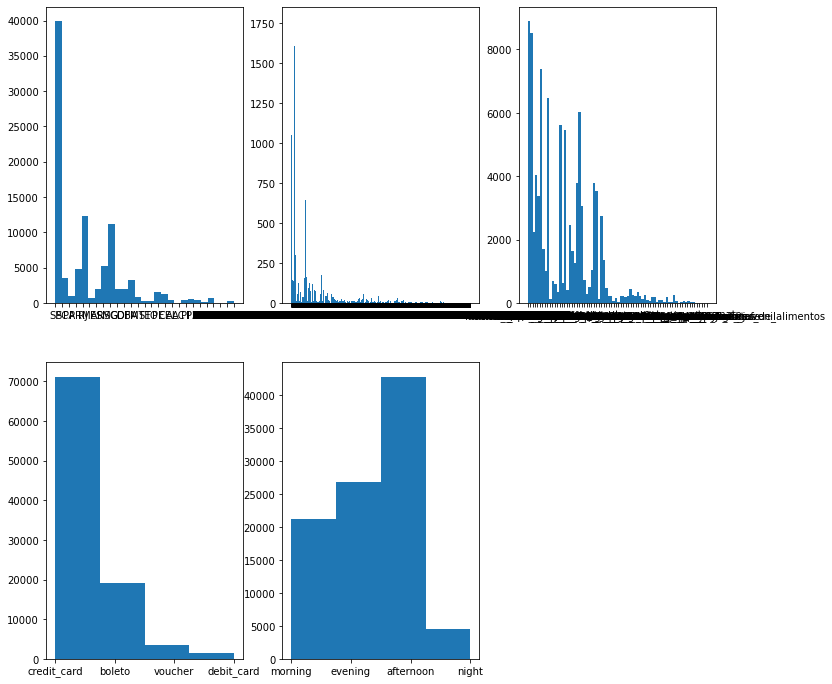

In [145]:
#On traite les variables catégorielles:
fig=plt.figure(figsize=(12,12))
plt.subplot(231)
plt.hist(data.state,bins=len(data.state.unique()))
plt.subplot(232)
plt.hist(data.seller_id,bins=len(data.seller_id.unique()),label=None)
plt.subplot(233)
plt.hist(data.product_category_name,bins=len(data.product_category_name.unique()),label=None)
plt.subplot(234)
plt.hist(data.favorite_payment,bins=len(data.favorite_payment.unique()),label=None)
plt.subplot(235)
plt.hist(data.period,bins=len(data.period.unique()),label=None)
plt.show()


In [146]:
#Pour les 3 premières, on va coder en proportion dans le tableau,
#Pour les 2 dernières on fera un One Hot et on verra.

In [147]:
data.shape

(95419, 17)

In [149]:
data.head()

,number_of_orders,state,Latitude,Longitude,period,total_payment_value,mean_installment,favorite_payment,ratio_freight,product_id,seller_id,nb_of_category,product_category_name,review_score,ecology,last_order_d,fréquency
customer_unique_id,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1.0,SP,-23.340235,-46.830140,morning,141.90,17.7375,credit_card,0.084567,1.0,da8622b14eb17ae2831f4ac5b9dab84a,1,cama_mesa_banho,5.0,1569.867304,937,0.001067
0000b849f77a49e4a4ce2b2a4ca5be3f,1.0,SP,-23.559115,-46.787626,morning,27.19,27.1900,credit_card,0.304892,1.0,138dbe45fc62f1e244378131a6801526,1,beleza_saude,4.0,80.771515,940,0.001064
0000f46a3911fa3c0805444483337064,1.0,SC,-27.542880,-48.633426,evening,86.22,10.7775,credit_card,0.199722,1.0,3d871de0142ce09b7081e2b9d1733cb1,1,papelaria,3.0,7076.706450,1363,0.000734
0000f6ccb0745a6a4b88665a16c9f078,1.0,PA,-1.312214,-48.483159,evening,43.62,10.9050,credit_card,0.404172,1.0,ef506c96320abeedfb894c34db06f478,1,telefonia,4.0,3348.014775,1147,0.000872
0004aac84e0df4da2b147fca70cf8255,1.0,SP,-23.505548,-47.469705,evening,196.89,32.8150,credit_card,0.085784,1.0,70a12e78e608ac31179aea7f8422044b,1,telefonia,5.0,9144.827324,1114,0.000898


In [150]:
data.columns

Index(['number_of_orders', 'state', 'Latitude', 'Longitude', 'period',
       'total_payment_value', 'mean_installment', 'favorite_payment',
       'ratio_freight', 'product_id', 'seller_id', 'nb_of_category',
       'product_category_name', 'review_score', 'ecology', 'last_order_d',
       'fréquency'],
      dtype='object')

In [151]:
data.columns=['total_number_of_orders', 'state', 'Latitude', 'Longitude',
       'favorite_period', 'total_payment_value', 'mean_installment',
       'favorite_payment_type', 'mean_ratio_freight', 'items_per_order',
       'favorite_seller_id', 'nb_of_category', 'favorite_category',
       'mean_review_score', 'ecology', 'days_since_last_order',
       'procurement_fréquency']

In [162]:
data.head(2)

,total_number_of_orders,state,Latitude,Longitude,favorite_period,total_payment_value,mean_installment,favorite_payment_type,mean_ratio_freight,items_per_order,favorite_seller_id,nb_of_category,favorite_category,mean_review_score,ecology,days_since_last_order,procurement_fréquency
customer_unique_id,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1.0,SP,-23.340235,-46.830140,morning,141.90,17.7375,credit_card,0.084567,1.0,da8622b14eb17ae2831f4ac5b9dab84a,1,cama_mesa_banho,5.0,1569.867304,937,0.001067
0000b849f77a49e4a4ce2b2a4ca5be3f,1.0,SP,-23.559115,-46.787626,morning,27.19,27.1900,credit_card,0.304892,1.0,138dbe45fc62f1e244378131a6801526,1,beleza_saude,4.0,80.771515,940,0.001064


In [154]:
#On sauvegarder dans 2 fichier:
data.to_csv('data.csv')
data[data.total_number_of_orders>1].to_csv('data2.csv')